# Train Forecast Model - Daily

In this notebook we'll train a deep learning model that learns if a target price or stop loss would be hit for a long/short trade in the next days based on historical price data.

Model:
* Multilayer Perceptron (MLP) (Feedforward neural network)
* 3 layers: input, hidden, output
* Binary Classification
* `Input`: Close, SMA(2 to 16), ROC(2 to 16)
* `Output`: Does a long or short trade hit the profit target (2%) without hitting a stop loss (1.5%) in the next five days?

In [1]:
%run ../2_Strategies/init_model.py 'model_long_short_predict'

model_long_short_predict


In [2]:
%%writefile local/{model_name}/input/config/hyperparameters.json
{ 
}

Overwriting local/model_long_short_predict/input/config/hyperparameters.json


# Step 1) Get Data from Athena and S3

In [3]:
# get S3 bucket
s3bucket=!(aws s3 ls | grep algotrading- | awk  '{print $3}')
s3bucket=s3bucket[0]
s3bucket

'algotrading-demo-ver1'

In [4]:
import sys
!{sys.executable} -m pip install PyAthena
!{sys.executable} -m pip install --upgrade numexpr

In [5]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()
region = sess.boto_session.region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [6]:
import pandas as pd
from sqlalchemy import create_engine
from pyathena import connect
connection_string = 'awsathena+rest://@'+region+'?s3_staging_dir=s3://'+s3bucket+'/results/'
engine = create_engine(connection_string)
df = pd.read_sql("SELECT dt,open,high,low,close,vol FROM algo_data.hist_data_daily;", engine)
df.set_index(pd.DatetimeIndex(df['dt']),inplace=True)
del df['dt']
df.head()

,open,high,low,close,vol
dt,,,,,
2012-08-13,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,26.57,26.63,26.21,26.33,30379903.0


In [7]:
df.to_csv('local/'+model_name+'/input/data/training/data_orig.csv')
print("count=%s" % len(df))
df.head()

count=1825


,open,high,low,close,vol
dt,,,,,
2012-08-13,26.76,26.83,26.41,26.69,23623918.0
2012-08-14,26.80,26.81,26.38,26.48,27477260.0
2012-08-15,26.23,26.47,26.19,26.27,26081909.0
2012-08-16,26.44,26.65,26.34,26.59,25702363.0
2012-08-17,26.57,26.63,26.21,26.33,30379903.0


<Axes: xlabel='dt'>

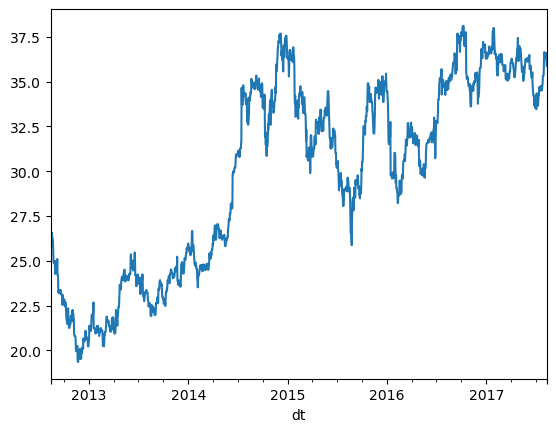

In [8]:
%matplotlib inline
df["close"].plot()

# Step 2) Run Data Preparation Locally

## Modify Data Preparation Code

In the following cell, you can modify the data preparation code or leave it as is.

In [9]:
%%writefile model/{model_name}_prep.py
#!/usr/bin/env python

import numpy as np
import pandas as pd
import talib as ta
from talib.abstract import *
import math

prefix = '/opt/ml/'
input_path = prefix + 'input/data/training'

data_orig_file = input_path+'/data_orig.csv'
data_file = input_path+'/data.csv'

d = pd.read_csv(data_orig_file,infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])
print(d.head())

repeatCount=15
repeatStep=1
lookBack=repeatCount*repeatStep
forwardWindow=5

profitTarget=2.0/100.0
stopTarget=1.5/100.0

iCount=lookBack

# header
hData=["dt"]
hData.append("close")
for a in range(0,repeatCount):
    hData.append("sma"+str((a+2)*repeatStep))
for a in range(0,repeatCount):
    hData.append("roc"+str((a+2)*repeatStep))
hData.append("long")
hData.append("short")

# data
tData=[]

inputs = {
    'close': np.array(d["close"])
}
sma=[]
for a in range(0,repeatCount):
    sma.append(SMA(inputs,timeperiod=(a+1)*repeatStep+1))
roc=[]
for a in range(0,repeatCount):
    roc.append(ROC(inputs,timeperiod=(a+1)*repeatStep+1))

closeList=d["close"]
dLen=len(d)
n=0
lCount=0
sCount=0
nCount=0
n=0
for idx,row in d.iterrows():
    if n<dLen-forwardWindow-1:
        dt1=idx
        cl=row["close"]
        inputRec=[]
        inputRec.append(idx)

        inputRec0=[]

        #close
        inputRec0.append(cl)

        #sma
        for a in range(0,repeatCount):
            if math.isnan(sma[a][n]):
                inputRec0.append(cl)
            else:
                inputRec0.append(sma[a][n])

        m1=min(inputRec0)
        m2=max(inputRec0)
        for a in inputRec0:
            if m2-m1==0:
                inputRec.append(0)
            else:
                inputRec.append((a-m1)/(m2-m1))

        #roc
        for a in range(0,repeatCount):
            if math.isnan(roc[a][n]):
                inputRec.append(0)
            else:
                inputRec.append(roc[a][n])

        rClose=closeList[n+1:min(dLen-1,n+1+forwardWindow)].values.tolist()
        low=min(rClose)
        high=max(rClose)
        
        #long
        long=0
        if high>=cl+cl*profitTarget and low>=cl-cl*stopTarget:
            long=1
            lCount=lCount+1
        inputRec.append(long)
 
        #short
        short=0
        if low<=cl-cl*profitTarget and high<=cl+cl*stopTarget:
            short=1
            sCount=sCount+1
        inputRec.append(short)

        tData.append(inputRec)
        n=n+1
          
print("lCount=%s,sCount=%s" % (lCount,sCount))
df1=pd.DataFrame(tData,columns=hData)
df1.set_index(pd.DatetimeIndex(df1['dt']), inplace=True)
del df1['dt']
 
df1.to_csv(data_file)
print(df1.head())
print("count=%s" % (len(df1)))

Overwriting model/model_long_short_predict_prep.py


## Run Data Preparation Locally in a Docker Container

In [10]:
!cp model/{model_name}_prep.py model/train
!chmod 777 model/train
!docker build -t {model_name}_prep .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name}_prep train

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (3/3)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.01kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
[+] Building 0.3s (13/20)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.01kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B         

[+] Building 0.9s (13/22)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.44kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [ 1/18] FROM docker.io/tensorflow/tensorflow:latest@sha256:f24e8494d4  0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 2.92kB                                        0.0s
 => CACHED [ 2/18] RUN apt-get -y update && apt-get install -y --no-insta  0.0s
 => CACHED [ 3/18] RUN wget https://sourceforge.net/projects/ta-lib/files  0.0s
 => CACHED [ 4/18] WORKDIR /tmp                                            0.0s
 => CACHED [ 5/18] RUN wget https://prdo

[+] Building 1.7s (14/22)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.44kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [ 1/18] FROM docker.io/tensorflow/tensorflow:latest@sha256:f24e8494d4  0.0s
 => [internal] load build context                                          0.0s
 => => transferring context: 2.92kB                                        0.0s
 => CACHED [ 2/18] RUN apt-get -y update && apt-get install -y --no-insta  0.0s
 => CACHED [ 3/18] RUN wget https://sourceforge.net/projects/ta-lib/files  0.0s
 => CACHED [ 4/18] WORKDIR /tmp                                            0.0s
 => CACHED [ 5/18] RUN wget https://prdo

## Create Training and Test Data

In [11]:
import pandas as pd
df = pd.read_csv("local/"+model_name+"/input/data/training/data.csv", parse_dates=['dt'], index_col=['dt'])
print("totalCount=%s" % len(df))

trainCount=int(len(df)*0.4)
dfTrain = df.iloc[:trainCount]
dfTrain.to_csv("local/"+model_name+"/input/data/training/data_train.csv")
print("trainCount=%s" % len(dfTrain))

dfTest = df.iloc[trainCount:]
dfTest.to_csv("local/"+model_name+"/input/data/training/data_test.csv")
print("testCount=%s" % len(dfTest))
dfTest.head()

totalCount=1819
trainCount=727
testCount=1092


,close,sma2,sma3,sma4,sma5,sma6,sma7,sma8,sma9,sma10,...,roc9,roc10,roc11,roc12,roc13,roc14,roc15,roc16,long,short
dt,,,,,,,,,,,,,,,,,,,,,
2014-08-10,3.797156e-14,2.278293e-14,0.000000,0.021376,0.068403,0.096192,0.303846,0.418170,0.507088,0.578223,...,-3.378779,-3.806433,-5.094614,-4.650483,-4.761905,-4.817518,-4.817518,-4.817518,1,0
2014-08-11,4.217463e-01,1.449753e-01,0.052718,0.006590,0.000000,0.030752,0.048953,0.265239,0.388065,0.486326,...,-2.133966,-2.133966,-2.567129,-3.871907,-3.422053,-3.534911,-3.591241,-3.591241,1,0
2014-08-12,5.806887e-01,4.915598e-01,0.234976,0.106685,0.029710,0.000000,0.015819,0.023633,0.251182,0.382984,...,-1.807943,-1.807943,-1.807943,-2.242549,-3.551674,-3.100322,-3.213555,-3.270073,1,0
2014-08-13,1.000000e+00,5.846813e-01,0.414843,0.240010,0.135109,0.065176,0.025010,0.012012,0.000000,0.095718,...,0.146843,1.066983,1.066983,1.066983,0.619652,-0.727802,-0.263235,-0.379784,0,0
2014-08-14,9.189463e-01,1.000000e+00,0.699426,0.521277,0.329281,0.201283,0.109857,0.051418,0.023978,0.000000,...,3.412553,-0.323054,0.592768,0.592768,0.592768,0.147536,-1.193595,-0.731208,0,0


# Step 3) Train the Model

In the following cell, you can modify the model training code or leave it as is.

In [12]:
%%writefile model/{model_name}.py
#!/usr/bin/env python
from __future__ import print_function

import os
import sys
import traceback
import math
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

yLen=2
b=0

# Optional
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# These are the paths to where SageMaker mounts interesting things in your
# container.
prefix = '/opt/ml/'

input_path = prefix + 'input/data/training/data_train.csv'
test_path = prefix + 'input/data/training/data_test.csv'

output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')

# Process and prepare the data
def data_process(df):
    global yLen
    global b
    dataX=[]
    dataY=[]
    for idx,row in df.iterrows():
        row1=[]
        r=row[1:len(row)-yLen]
        for a in r:
            row1.append(a)
        x=np.array(row1)
        y=np.array(row[len(row)-yLen:])
        b=len(x)
        dataX.append(x)
        dataY.append(y)
    dataX=np.array(dataX).astype(np.float32)
    dataY=np.array(dataY).astype(np.float32)
    return dataX,dataY,b

def build_classifier():
    global b
    global yLen
    print("build_classifier:b=%s,yLen=%s" % (b,yLen))
    model = Sequential()
    model.add(Dense(b, input_dim=b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(yLen,kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def generate_model(dataX, dataY, b):
    model=build_classifier()
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    return model
        
def train():
    print('Starting the training.')
    try:
        raw_data = pd.read_csv(input_path)
        #print(raw_data)
        X, y, b = data_process(raw_data)
        model = generate_model(X, y, b)
        model.save(os.path.join(model_path, 'model.h5'))
        
        print('Training is complete. Model saved.')
        
        raw_data = pd.read_csv(test_path)
        testX, testY, b = data_process(raw_data)
        scores = model.evaluate(testX, testY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Overwriting model/model_long_short_predict.py


### Option 1: Train Locally

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [13]:
# Build Local ML Image
!cp model/{model_name}.py model/train
!chmod 777 model/train
!docker build -t {model_name} .
!docker run -v $(pwd)/local/$model_name:/opt/ml --rm {model_name} train

[+] Building 0.0s (1/1)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
[+] Building 0.1s (3/18)                                         docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.01kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
[+] Building 0.3s (13/20)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.01kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
 => [internal] load .dockerignore       

#### Copy Model Artifact to Strategies Folder

In [14]:
!ls -la local/{model_name}/model/model.h5
!cp local/{model_name}/model/model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la ../2_Strategies/model/model_*.h5

-rw-r--r-- 1 root root 45936 Jun 12 16:27 local/model_long_short_predict/model/model.h5
-rw-rw-r-- 1 ec2-user ec2-user 45936 Jun 12 16:27 ../2_Strategies/model/model_long_short_predict.h5


### Option 2: Remote Training via SageMaker

You can choose if you want to do the training locally (Option 1) or remote via SageMaker (Option 2).

In [15]:
# Deploy ML Image to ECS
!./build_and_push.sh $model_name

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.01kB                                     0.0s
 => [internal] load metadata for docker.io/tensorflow/tensorflow:latest    0.1s
[+] Building 0.3s (13/20)                                        docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 1.01kB                                     0.0s
 => [internal] load metadata for docker.io/te

In [16]:
import os
import sagemaker as sage
from sagemaker import get_execution_role
import datetime
from sagemaker.tensorflow import TensorFlow
import json

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local/'+model_name+'/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

conf_file='local/'+model_name+'/input/config/hyperparameters.json'
with open(conf_file, 'r') as f:
    config = json.load(f)
print(config)

prefix=model_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

classifier = sage.estimator.Estimator(
    image_uri=image,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name)
classifier.fit(data_location)

INFO:sagemaker:Creating training-job with name: model-long-short-predict-2025-06-12-16-28-06-135


s3://sagemaker-us-east-1-616431823260/data
{}
2025-06-12 16:28:08 Starting - Starting the training job...
2025-06-12 16:28:23 Starting - Preparing the instances for training...
2025-06-12 16:28:45 Downloading - Downloading input data...
2025-06-12 16:29:15 Downloading - Downloading the training image...
2025-06-12 16:30:01 Training - Training image download completed. Training in progress..Using TensorFlow backend.
Starting the training.
build_classifier:b=31,yLen=2
2025-06-12 16:30:05.006992: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
Epoch 1/100
727/727 [==============================] - 1s 1ms/step - loss: 0.5835 - accuracy: 0.7620
Epoch 2/100
727/727 [==============================] - 1s 1ms/step - loss: 0.5411 - accuracy: 0.7772
Epoch 3/100
727/727 [==============================] - 1s 917us/step - loss: 0.5374 - accuracy: 0.7772
Epoch 4/100
727/727 [==============================] - 1s 907us/step - loss: 0.5283 - accuracy: 0.7

#### Download Model Artifact from Amazon S3 and copy it to Strategies Folder

In [17]:
#Get Model from S3
model_name_s3=classifier.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name_s3,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
!cp model.h5 ../2_Strategies/model/{model_name}.h5
!ls -la model.h5
!ls -la ../2_Strategies/model/model_*.h5

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
-rw-r--r-- 1 ec2-user ec2-user 45936 Jun 12 16:31 model.h5
-rw-rw-r-- 1 ec2-user ec2-user 45936 Jun 12 16:31 ../2_Strategies/model/model_long_short_predict.h5
